<a href="https://colab.research.google.com/github/MatruPrasad09/Forecast-Cab-Booking-Demand/blob/main/Cab_Booking__Demand_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast Cab Booking Demand
## Mid-Program Project 1

## 1. Import the required libraries and load the training and testing dataset 

In [ ]:
## all imports here

import numpy as np
import pandas as pd
import calendar
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
#Import Regression Models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

#evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score



In [ ]:
##loading training and testing data
train_path = "/content/train.csv"
train_label_path = "/content/train_label.csv"
test_path = "/content/test.csv"
test_label_path = "/content/test_label.csv"

##read data from csv files
train = pd.read_csv(train_path)
train_label = pd.read_csv(train_label_path, header= None)
test = pd.read_csv(test_path)
test_label = pd.read_csv(test_label_path, header= None)

## 2 a. Check the shape of the training and testing set

In [ ]:
## shape of training and test data
print(train.shape)
print(train_label.shape)
print(test.shape)
print(test_label.shape)

(8708, 9)
(8708, 1)
(2178, 9)
(2178, 1)


In [ ]:
print(train_label.head())
print(test_label.head())
train.columns
test.columns


     0
0  504
1    5
2  139
3  209
4  184
     0
0  256
1   87
2   11
3   84
4  668


Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [ ]:
## appending the train_label dataset to train.csv as ‘Total_booking’ column
train['Total_booking'] = train_label[0]
##similarly for test dataset
test['Total_booking'] = test_label[0]

In [ ]:
print(train.head())
print('*'* 100)
print(test.head())

           datetime  season  holiday  ...  humidity windspeed  Total_booking
0    5/2/2012 19:00  Summer        0  ...        77   16.9979            504
1     9/5/2012 4:00    Fall        0  ...        79   19.0012              5
2    1/13/2011 9:00  Spring        0  ...        50   22.0028            139
3  11/18/2011 16:00  Winter        0  ...        29    8.9981            209
4   9/13/2011 13:00    Fall        0  ...        51   19.0012            184

[5 rows x 10 columns]
****************************************************************************************************
           datetime  season  holiday  ...  humidity windspeed  Total_booking
0   5/10/2012 11:00  Summer        0  ...        48   35.0008            256
1     6/9/2012 7:00  Summer        0  ...        64    7.0015             87
2    3/6/2011 20:00  Spring        0  ...       100   27.9993             11
3  10/13/2011 11:00  Winter        0  ...        83    0.0000             84
4    6/2/2012 12:00  Summer  

## 2b. Print the data types of each column

In [ ]:
print(train.dtypes)

datetime          object
season            object
holiday            int64
workingday         int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
Total_booking      int64
dtype: object


## 2c. Check the missing values present in the dataset

In [ ]:
print(train.isna().sum())
print('*'* 100)
print(test.isna().sum())

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64
****************************************************************************************************
datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64


# 3. Feature Engineering

a. Create new columns date, hour, weekDay, month from datetime column

b. Coerce the datatype of season, holiday, workingday, and weather to category

c. Drop the datetime column as we have already extracted useful features from it

In [ ]:
# train['datetime'] = train['datetime'].str.replace('/' , '-')
# train['date'] = train.datetime.apply(lambda x : x.split()[0])
# train['hour'] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])

##convert datetime series to datetime object
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

##Create new columns date, hour, weekDay, month from datetime column for both train and test dataset 
##Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day_name.html
train['date'] = train.datetime.dt.date
train['hour'] = train.datetime.dt.hour
train['weekDay'] = train.datetime.dt.day_name()
train['month'] = train.datetime.dt.month_name()

test['date'] = test.datetime.dt.date
test['hour'] = test.datetime.dt.hour
test['weekDay'] = test.datetime.dt.day_name()
test['month'] = test.datetime.dt.month_name()


In [ ]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekDay,month
0,2012-05-02 19:00:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02,19,Wednesday,May
1,2012-09-05 04:00:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05,4,Wednesday,September
2,2011-01-13 09:00:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011-01-13,9,Thursday,January
3,2011-11-18 16:00:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011-11-18,16,Friday,November
4,2011-09-13 13:00:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011-09-13,13,Tuesday,September


In [ ]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekDay,month
0,2012-05-10 11:00:00,Summer,0,1,Clear + Few clouds,21.32,25.000,48,35.0008,256,2012-05-10,11,Thursday,May
1,2012-06-09 07:00:00,Summer,0,0,Clear + Few clouds,23.78,27.275,64,7.0015,87,2012-06-09,7,Saturday,June
2,2011-03-06 20:00:00,Spring,0,0,"Light Snow, Light Rain",11.48,12.120,100,27.9993,11,2011-03-06,20,Sunday,March
3,2011-10-13 11:00:00,Winter,0,1,Mist + Cloudy,25.42,28.790,83,0.0000,84,2011-10-13,11,Thursday,October
4,2012-06-02 12:00:00,Summer,0,0,Clear + Few clouds,25.42,31.060,43,23.9994,668,2012-06-02,12,Saturday,June


In [ ]:
## coerce the datatype of season, holiday, workingday and weather to category
categorical_cols = ['season', 'holiday', 'workingday', 'weather']
for col in categorical_cols:
  train[col] = train[col].astype('category')
  test[col] = test[col].astype('category')

In [ ]:
train.dtypes

datetime         datetime64[ns]
season                 category
holiday                category
workingday             category
weather                category
temp                    float64
atemp                   float64
humidity                  int64
windspeed               float64
Total_booking             int64
date                     object
hour                      int64
weekDay                  object
month                    object
dtype: object

In [ ]:
##drop the datetime column as we have already extracted useful features from it
train = train.drop('datetime', axis=1)
test = test.drop('datetime', axis=1)


In [ ]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekDay,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011-01-13,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011-11-18,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011-09-13,13,Tuesday,September


## **4. Perform Outlier Analysis:**

a. Plot Box plots across various features like season, hour of the day, working_day, etc
to see if there are any Outlier and note down your inference

b. Remove the outliers present in the dataset

[Text(0.5, 1.0, 'Box plot of Total booking across working day')]

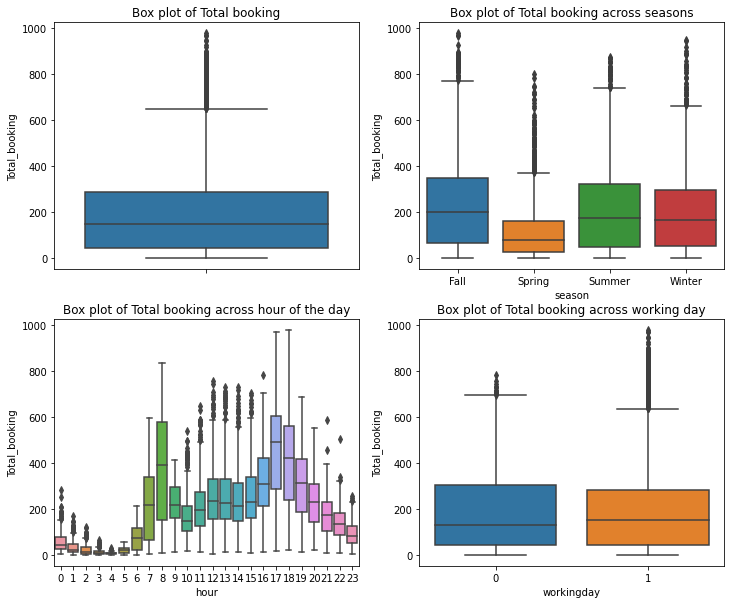

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(y='Total_booking', data=train, ax=axes[0][0]).set(title = 'Box plot of Total booking')
sns.boxplot(x='season', y='Total_booking', data=train, ax=axes[0][1]).set(title = 'Box plot of Total booking across seasons')
sns.boxplot(x='hour', y='Total_booking', data=train, ax=axes[1][0]).set(title = 'Box plot of Total booking across hour of the day')
sns.boxplot(x='workingday', y='Total_booking', data=train, ax=axes[1][1]).set(title = 'Box plot of Total booking across working day')

Inference made from above box plots:



*   The total number of bookings made in Spring season is relatively lower than others.
*   There is a peak in bookings made between 7am-8am and 5pm-6pm, this surge could be due to regular school and office hours.
*   Number of outliers in working day is more than in a non-working day






In [ ]:
##Removing Outliers
##USING STATS FROM SCIPY
# z_scores = stats.zscore(train)
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# train_without_outlier = train[filtered_entries]


##USING THE FORMULA DIRECTLY
## keeps only the values that are within +3 to -3 standard deviations in the column 'Total_booking'.
train_without_outlier = train[np.abs(train.Total_booking-train.Total_booking.mean()) <= (3*train.Total_booking.std())]

print(train.shape)
print(test.shape)
print(train_without_outlier.shape)
train_without_outlier.head()

(8708, 13)
(2178, 13)
(8591, 13)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekDay,month
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02,19,Wednesday,May
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05,4,Wednesday,September
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011-01-13,9,Thursday,January
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011-11-18,16,Friday,November
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011-09-13,13,Tuesday,September


In [ ]:
train_without_outlier['weekDay'].value_counts()
# train_without_outlier['season'].value_counts()


Saturday     1272
Sunday       1261
Monday       1230
Thursday     1218
Friday       1211
Tuesday      1206
Wednesday    1193
Name: weekDay, dtype: int64

In [ ]:
train_without_outlier.dtypes

season           category
holiday          category
workingday       category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
Total_booking       int64
date               object
hour                int64
weekDay            object
month              object
dtype: object

# 5. Perform Correlation Analysis:
a. Plot a correlation plot between "total booking" and ["temp", "atemp", "humidity",
"windspeed"]

b. Write down your inference in the markdown cell

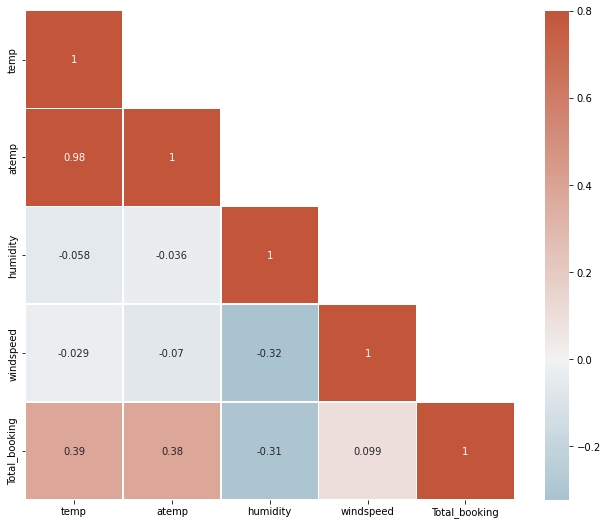

In [ ]:
corr_matrix = train_without_outlier[["temp", "atemp", "humidity", "windspeed", "Total_booking"]].corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, annot=True, linewidths=.5)

## Inference from Correlation plot above:

*   atemp and temp have very postive correlation, so we can drop one of them during model building to avoid multi-collinearity in the data.
*   temp and humidity has positive and negative correlation with Total_booking, although not much significant. 
*   Windspeed has very less correlation with Total_booking, hence it's not of much use.



## 6. Perform Data Visualization: 
a. Visualize distribution of data: total_booking column and plot the probability distribution plot for the column as well

b. Visualize total_booking vs (Month, Season, Hour, Weekday, Usertype)

c. Use Histograms to plot all the continuous variables present in the data

((array([-3.77290246, -3.54563229, -3.42075996, ...,  3.42075996,
          3.54563229,  3.77290246]),
  array([0.        , 0.        , 0.        , ..., 6.5971457 , 6.60258789,
         6.60258789])),
 (1.4051607785863067, 4.535872940407394, 0.9530345295109863))

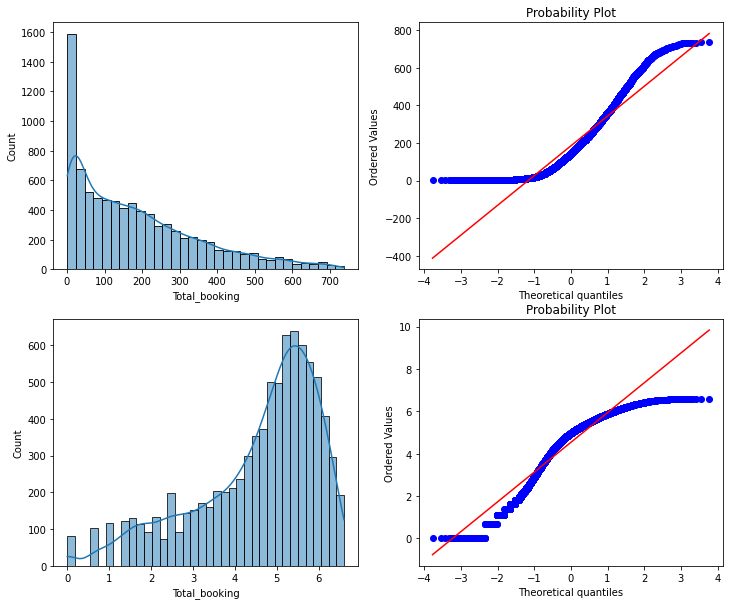

In [ ]:
##Visualize data distribution for Total_booking column

fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)
sns.histplot(train_without_outlier['Total_booking'], kde=True, ax=axes[0][0])
stats.probplot(train_without_outlier['Total_booking'], fit=True, plot=axes[0][1])
sns.histplot(np.log(train_without_outlier['Total_booking']), kde=True, ax=axes[1][0])
stats.probplot(np.log(train_without_outlier['Total_booking']), fit=True, plot=axes[1][1])

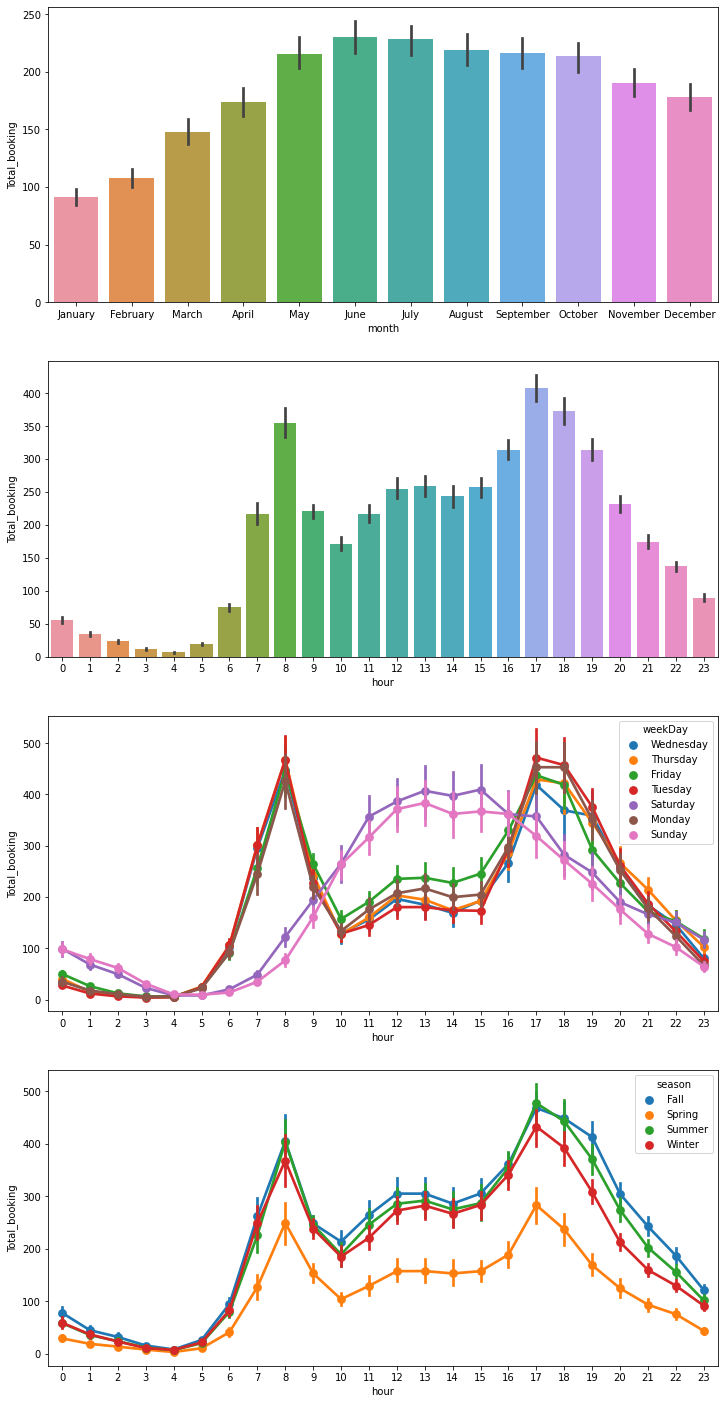

In [ ]:
##visualize total_booking vs (Month, Season, Hour, Weekday, Usertype)
fig, axes = plt.subplots(nrows=4)
fig.set_size_inches(12, 25)
sortOrder= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hueOrder = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='month', y='Total_booking', data=train_without_outlier, order=sortOrder, ax=axes[0])
sns.barplot(x='hour', y='Total_booking', data=train_without_outlier, ax=axes[1])
sns.pointplot(x='hour', y='Total_booking', hue='weekDay', data=train_without_outlier, ax=axes[2])
sns.pointplot(x='hour', y='Total_booking', hue='season', data=train_without_outlier, ax=axes[3])

Inference from above plots:

*   Total booking is relatively higher in Summers months(June, July, Aug)
*   There is a peak in bookings made between 7am-8am and 5pm-6pm, this surge could be due to regular school and office hours.




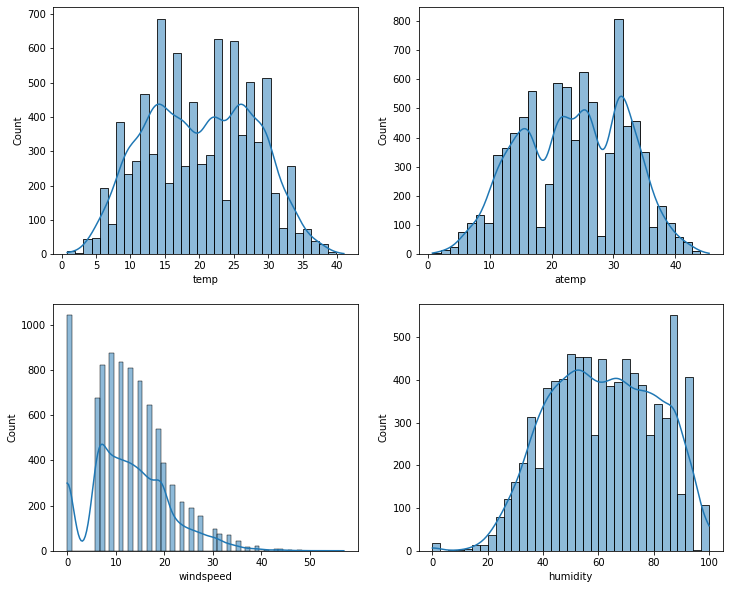

In [ ]:
##Histograms to plot all the continuous variables present in the data
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.histplot(data=train_without_outlier, x='temp', kde=True, ax=axes[0][0])
sns.histplot(data=train_without_outlier, x='atemp', kde=True, ax=axes[0][1])
sns.histplot(data=train_without_outlier, x='windspeed', kde=True, ax=axes[1][0])
sns.histplot(data=train_without_outlier, x='humidity', kde=True, ax=axes[1][1])

In [ ]:
#Combining both Train and Test data
fullData = train_without_outlier.append(test, sort=False)
fullData.reset_index(inplace=True)
fullData.drop('index',inplace=True, axis=1)
print(fullData.shape)

categorical_cols = ['weekDay', 'month', 'season', 'weather']
for col in categorical_cols:
  fullData[col] = fullData[col].astype('category')

numerical_cols = ['holiday', 'workingday']
for ncol in numerical_cols:
  fullData[ncol] = fullData[ncol].astype('int64')
fullData.dtypes


(10769, 13)


season           category
holiday             int64
workingday          int64
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
Total_booking       int64
date               object
hour                int64
weekDay          category
month            category
dtype: object

# 7. Convert the categorical variables into one hot vector

In [ ]:
##convert the categorical variables into one hot vector 
season = pd.get_dummies(fullData['season'])
fullData = pd.concat([fullData, season], axis=1)

weather = pd.get_dummies(fullData['weather'])
fullData = pd.concat([fullData, weather], axis=1)

weekDay = pd.get_dummies(fullData['weekDay'])
fullData = pd.concat([fullData, weekDay], axis=1)

month = pd.get_dummies(fullData['month'])
fullData = pd.concat([fullData, month], axis=1)

print(fullData.shape)
fullData.head()

(10769, 40)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,Total_booking,date,hour,weekDay,month,Fall,Spring,Summer,Winter,Clear + Few clouds,Heavy Rain + Thunderstorm,"Light Snow, Light Rain",Mist + Cloudy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012-05-02,19,Wednesday,May,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012-09-05,4,Wednesday,September,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011-01-13,9,Thursday,January,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011-11-18,16,Friday,November,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011-09-13,13,Tuesday,September,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
## drop irrelevant columns
fullData.drop(['season', 'weather',	'weekDay', 'month', 'date', 'atemp'], inplace=True, axis=1)
print(fullData.shape)
fullData.head()

(10769, 34)


,holiday,workingday,temp,humidity,windspeed,Total_booking,hour,Fall,Spring,Summer,Winter,Clear + Few clouds,Heavy Rain + Thunderstorm,"Light Snow, Light Rain",Mist + Cloudy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
0,0,1,22.14,77,16.9979,504,19,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,28.70,79,19.0012,5,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,5.74,50,22.0028,139,9,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,13.94,29,8.9981,209,16,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,30.34,51,19.0012,184,13,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


# 8. Split your dataset for training and testing 

In [ ]:
df_train = fullData[:train_without_outlier.shape[0]]
df_test = fullData[train_without_outlier.shape[0]:]

print(df_train.shape)
print(df_test.shape)
#dropping Label from Test data
df_test.drop(['Total_booking'], inplace=True, axis=1)

X = df_train.copy() # Features
#dropping Label from Training data
X.drop(['Total_booking'], inplace=True, axis=1)
y = df_train['Total_booking']  # Label

print(X.shape)
print(y.shape)

# Split dataset into training set and test set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100) # 70% training and 30% test

print(X_valid.shape)
print(y_valid.shape)
print(X_train.shape)
print(y_train.shape)
df_test.head()

(8591, 34)
(2178, 34)
(8591, 33)
(8591,)
(2578, 33)
(2578,)
(6013, 33)
(6013,)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,holiday,workingday,temp,humidity,windspeed,hour,Fall,Spring,Summer,Winter,Clear + Few clouds,Heavy Rain + Thunderstorm,"Light Snow, Light Rain",Mist + Cloudy,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September
8591,0,1,21.32,48,35.0008,11,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8592,0,0,23.78,64,7.0015,7,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8593,0,0,11.48,100,27.9993,20,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8594,0,1,25.42,83,0.0000,11,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8595,0,0,25.42,43,23.9994,12,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# 9. Fit various models (Random Forest Regressor, Ada Boost Regressor, Bagging Regressor,SVR, and K-Neighbors Regressor) 

In [ ]:
#Implementing K-fold and fitting various models
seed = 100
kfold = KFold(n_splits=10, random_state=seed)
num_trees = 200

model_br = BaggingRegressor(n_estimators=num_trees, random_state=seed)
model_rf = RandomForestRegressor(n_estimators=num_trees, random_state=seed)
model_abr = AdaBoostRegressor(n_estimators=num_trees, random_state=seed)
model_svr = SVR()
model_knr = KNeighborsRegressor()

all_models_names =[]
RMSLE_values =[]
models = [model_br, model_rf, model_abr, model_svr, model_knr]
for model in models:
  model_name = str(model).partition('(')[0] #Partitioning the text and keeping only the head [0], which is model name
  result = cross_val_score(model, X_train, y_train, cv=kfold) #Calculating cross validation Score
  print('\n')
  print(f"Mean cross validation score of {model_name}: ", result.mean())
  model.fit(X_train, y_train)
  y_pred = model.predict(X_valid)
  print(f"RMSE of {model_name}: ", np.sqrt(mean_squared_error(y_valid, y_pred)))
  RMSLE = np.sqrt(mean_squared_log_error(y_valid, y_pred))
  print(f"RMSLE of {model_name}: ", RMSLE)
  all_models_names.append(model_name)
  RMSLE_values.append(RMSLE)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning




Mean cross validation score of BaggingRegressor:  0.8552038342818739
RMSE of BaggingRegressor:  64.05247181031353
RMSLE of BaggingRegressor:  0.4117371406483682


Mean cross validation score of RandomForestRegressor:  0.8553645653888384
RMSE of RandomForestRegressor:  64.06529105006285
RMSLE of RandomForestRegressor:  0.41153812294395853


Mean cross validation score of AdaBoostRegressor:  0.5113956801683759
RMSE of AdaBoostRegressor:  116.70315831983763
RMSLE of AdaBoostRegressor:  0.963024124837311


Mean cross validation score of SVR:  0.18931912929126432
RMSE of SVR:  145.363086699157
RMSLE of SVR:  1.1950236412577082


Mean cross validation score of KNeighborsRegressor:  0.5173099250955799
RMSE of KNeighborsRegressor:  112.1961642426002
RMSLE of KNeighborsRegressor:  0.8934506866484754


# 10. Display a Factor plot to visualize the RMSE values achieved by different modeling algorithm 

In [ ]:
rmsle_data = list(zip(all_models_names, RMSLE_values))
df_rmsle = pd.DataFrame(rmsle_data, columns=['Model_Name', 'RMSLE'])
df_rmsle


,Model_Name,RMSLE
0,BaggingRegressor,0.411737
1,RandomForestRegressor,0.411538
2,AdaBoostRegressor,0.963024
3,SVR,1.195024
4,KNeighborsRegressor,0.893451


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


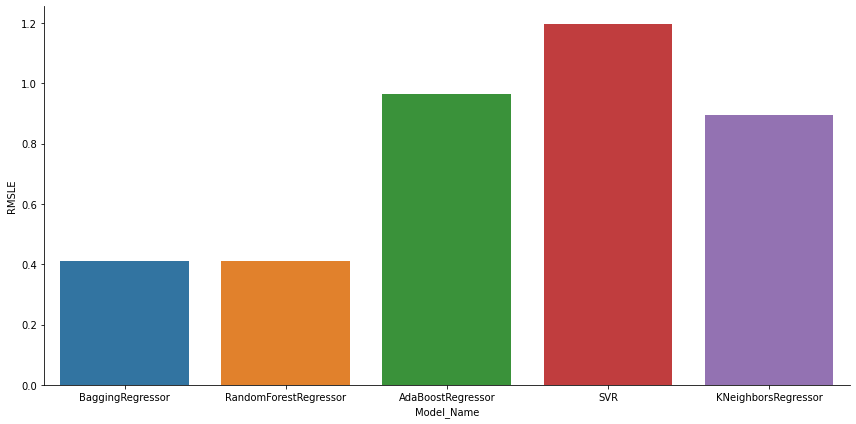

In [ ]:
##Factor plot to visualize the RMSE values achieved by different modeling algorithm
sns.factorplot(x='Model_Name', y='RMSLE', data=df_rmsle, kind='bar', size=6, aspect=2)

### Least RMSLE value is obtained by Random Forest Regressor Model, so we will use the same model for Hyperparameter tuning.

# 11. Perform Hyper-parameter tuning on the best model using GridSearchCV and print the best parameters using model.best_params_ 

In [ ]:
##Using Random Forest Regressor and GridSearchCV to get the best parameters

param_grid = {
    'max_features':["auto","sqrt", "log2"],
    'n_estimators': [300, 500, 700]
}
rf_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, n_jobs=-1, verbose=3)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_valid)
print("\n RMSLE: ", np.sqrt(mean_squared_log_error(y_valid, y_pred)))
rf_model.best_params_



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.3min finished



 RMSLE:  0.4117867581376004


{'max_features': 'auto', 'n_estimators': 300}

# 12. Perform prediction on the test set and print the mean_squared_log_error 

In [ ]:
pred = rf_model.predict(df_test)

In [ ]:
print(pred.shape)
print(test_label.shape)

(2178,)
(2178, 1)


In [ ]:
test_array = test_label.values.reshape(test_label.shape[0])

In [ ]:
test_array.shape

(2178,)

In [ ]:
df = pd.DataFrame(y_pred)
print("RMSLE: ", np.sqrt(mean_squared_log_error(test_array, y_pred)))

RMSLE:  0.864928451207823
